<h1><center> Tic-Tac-Toe using Reinforcement Learning  </center></h1>

- <a href='#1'>1. Importing libraries</a>
- <a href='#2'>2. Epsilon-greedy strategy</a>
- <a href='#3'>3. Tracking the state-action pairs for checking convergence</a>
- <a href='#4'>4. Define Parameters </a>
- <a href='#5'>5. Q-update loop </a>
- <a href='#6'>6. Check the Q-dictionary </a> 
- <a href='#7'>7. Check the states tracked for Q-values convergence </a>
- <a href='#8'>8. Epsilon - decay check </a>

## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### <a id='1'>Importing libraries </a>
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
#- import your class from environment file
from TCGame_Env1 import TicTacToe 
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### <a id='2'> Epsilon-greedy strategy </a>

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, episode):
    epsilon_max = 1.0
    epsilon_min = 0.001
    epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-0.000001*episode)
    epsilon_random = np.random.random()
    state1 = Q_state(state)    
    if epsilon_random > epsilon:
        #Exploitation: action corresponding to max q-value of current state
        action = max(Q_dict[state1],key=Q_dict[state1].get)   
    else:
        #Exploration: randomly choosing action
        action = random.choice([x for x in valid_actions(state)])    
    
    return action

#### <a id='3'> Tracking the state-action pairs for checking convergence </a>

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

In [7]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],(7,9)),
                       ([np.nan,np.nan,np.nan,9,np.nan,np.nan,np.nan,4,np.nan],(6,5)),
                       ([9,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,2,np.nan],(2,3)),
                       ([np.nan,np.nan,np.nan,np.nan,np.nan,6,5,np.nan,np.nan],(7,7))]    #select any 4 Q-values
    print(sample_q_values)
    for q_values in sample_q_values:
        state = Q_state(q_values[0])
        action = q_values[1]
        States_track[state][action] = []

In [8]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
# Initialize the Enviorenment
env = TicTacToe()
# Initialize tracking states
initialise_tracking_states()

[([nan, nan, nan, nan, nan, nan, nan, nan, nan], (7, 9)), ([nan, nan, nan, 9, nan, nan, nan, 4, nan], (6, 5)), ([9, nan, nan, nan, nan, nan, nan, 2, nan], (2, 3)), ([nan, nan, nan, nan, nan, 6, 5, nan, nan], (7, 7))]


#### <a id='4'> Define hyperparameters </a>

In [11]:
EPISODES = 5000000
# EPISODES = 4000000
# EPISODES = 2500000
# EPISODES = 1000000
# EPISODES = 100000
#EPISODES = 10
LR = 0.01                   
GAMMA = 0.91
threshold = 2000
policy_threshold = 30000

### <a id='5'> Q-update loop </a>

In [12]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe()
    curr_state = env.state
    add_to_dict(curr_state)
    done = False
    total_reward = 0
    while not done:
        curr_action = epsilon_greedy(curr_state,episode)
        curr_state_string = Q_state(curr_state)
        next_state,reward,done = env.step(curr_state,curr_action)
        if not done:
            add_to_dict(next_state)
            next_state_string = Q_state(next_state)
            next_max_value = max(Q_dict[next_state_string],key=Q_dict[next_state_string].get)
            Q_dict[curr_state_string][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_string][next_max_value]))) - Q_dict[curr_state_string][curr_action] ) 
        else:
            Q_dict[curr_state_string][curr_action] += LR * (reward  - Q_dict[curr_state_string][curr_action] ) 
        curr_state = next_state
        total_reward+=reward
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    #every 30000th episodes, the Q-dict will be saved
    if ((episode+1)% policy_threshold ) == 0:  
        print('***** Policy at episode # '+str(episode))
        save_obj(Q_dict,'Policy')
    
elapsed_time = time.time() - start_time
print(elapsed_time)
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

***** Policy at episode # 29999
***** Policy at episode # 59999
***** Policy at episode # 89999
***** Policy at episode # 119999
***** Policy at episode # 149999
***** Policy at episode # 179999
***** Policy at episode # 209999
***** Policy at episode # 239999
***** Policy at episode # 269999
***** Policy at episode # 299999
***** Policy at episode # 329999
***** Policy at episode # 359999
***** Policy at episode # 389999
***** Policy at episode # 419999
***** Policy at episode # 449999
***** Policy at episode # 479999
***** Policy at episode # 509999
***** Policy at episode # 539999
***** Policy at episode # 569999
***** Policy at episode # 599999
***** Policy at episode # 629999
***** Policy at episode # 659999
***** Policy at episode # 689999
***** Policy at episode # 719999
***** Policy at episode # 749999
***** Policy at episode # 779999
***** Policy at episode # 809999
***** Policy at episode # 839999
***** Policy at episode # 869999
***** Policy at episode # 899999
***** Policy 

In [13]:
States_track

defaultdict(dict,
            {'9-x-x-x-x-x-x-2-x': {(2, 3): [0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0

#### <a id='6'> Check the Q-dictionary </a>

In [14]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.2981617696674967,
              (0, 3): -0.5350526098587862,
              (0, 5): -1.1558833818160525,
              (0, 7): -1.3344276994006072,
              (0, 9): -1.3317346964985515,
              (1, 1): -1.2169517852060336,
              (1, 3): 1.7492809300727723,
              (1, 5): -0.9940025708618373,
              (1, 7): -1.2409941538912763,
              (1, 9): -1.1864014909430278,
              (2, 1): -1.2395416812170366,
              (2, 3): -1.236004970664825,
              (2, 5): -1.344199145692001,
              (2, 7): 5.618802837447613,
              (2, 9): -1.1254779526618095,
              (3, 1): -1.1406657803677422,
              (3, 3): -1.2017329560983752,
              (3, 5): -1.3479103316123027,
              (3, 7): -1.242884519165994,
              (3, 9): -1.2591301138473594,
              (4, 1): -1.349347109086495,
              (4, 3): -1.3593919444475553,
              (4, 5): 

In [15]:
len(Q_dict)

1814605

In [16]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
Q_dict['x-x-x-x-5-x-x-6-x']

{(0, 1): -0.4593276723431414,
 (0, 3): -0.4599368182593424,
 (0, 7): -0.4607293314069819,
 (0, 9): -0.45930699019717725,
 (1, 1): -0.45869059781081123,
 (1, 3): -0.4591703180112457,
 (1, 7): -0.4637317747928147,
 (1, 9): -0.462286343055593,
 (2, 1): -0.45993897385630533,
 (2, 3): -0.5644026088735614,
 (2, 7): -0.5247981788000541,
 (2, 9): -0.5546836051087999,
 (3, 1): -0.565065920518886,
 (3, 3): -0.46542551039292446,
 (3, 7): -0.4811307982470185,
 (3, 9): -0.46020146586787075,
 (5, 1): -0.4595105187939761,
 (5, 3): -0.5406050433128665,
 (5, 7): -0.45999488379557113,
 (5, 9): -0.5496129589492827,
 (6, 1): -0.5254719384583751,
 (6, 3): -0.5225498726450485,
 (6, 7): -0.5140004784579766,
 (6, 9): -0.5216062823477022,
 (8, 1): -0.45846870576346194,
 (8, 3): -0.4627976620454811,
 (8, 7): -0.5104720084012397,
 (8, 9): -0.47913603631793317}

In [17]:
max(Q_dict['x-x-x-x-5-x-x-6-x'],key=Q_dict['x-x-x-x-5-x-x-6-x'].get)

(8, 1)

#### <a id='7'> Check the states tracked for Q-values convergence </a>
(non-evaluative)

In [18]:
# Write the code for plotting the graphs for state-action pairs tracked

In [19]:
States_track

defaultdict(dict,
            {'9-x-x-x-x-x-x-2-x': {(2, 3): [0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0

In [20]:
z_action = []
z_action_value = []
for key in States_track.keys():
    z_action.append(key)
    for key2 in States_track[key]:
        z_action_value.append(States_track[key][key2])

In [21]:
len(z_action)

4

In [22]:
len(z_action_value)

4

In [23]:
[len(x) for x in z_action_value]

[2500, 2499, 2500, 2499]

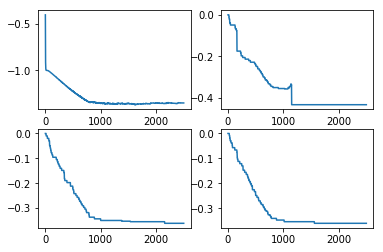

In [24]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(z_action_value[i])

### <a id='8'> Epsilon - decay check </a>

In [25]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,500000)
epsilon = []
for i in range(0,500000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.00001*i))

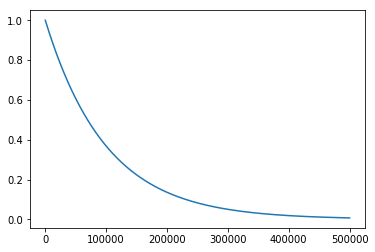

In [26]:
plt.plot(time, epsilon)
plt.show()